# Aurora Regridding, Testing, Visualization

In [1]:
import os
import sys

sys.path.append('../')

print(os.getcwd())
print(os.listdir())

/home/jgib124/aurora/aurora/afwerx
['__pycache__', 'aurora_regridding_process.ipynb', 'visualize.py', 'configs', 'tile_server.py', 'serve', 'tiles', 'aurora_inference_simple.py']


In [2]:
import yaml
import os
from argparse import ArgumentParser
from PIL import Image
import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt
import cfgrib
from datetime import datetime
from io import BytesIO
import boto3
from botocore.exceptions import ClientError
import ast
import xesmf as xe
from cartopy import crs as ccrs, feature as cfeature


from inference.generate_outputs import generate_outputs
from data.era5_download import download_era5, make_batch
from tile_server import save_tile, tile_into_folders

from aurora import Aurora

/home/jgib124/miniconda3/envs/aurora_test/lib/python3.11/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(
/home/jgib124/miniconda3/envs/aurora_test/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Wasabi: 
	Endpoint:  https://s3.wasabisys.com/
	Bucket:  aa-archiver
IDrive: 
	Endpoint:  https://l5l2.va.idrivee2-56.com
	Bucket:  archive-mosaics


## Batch Preparation

In [3]:
print(os.getcwd())
print(os.listdir())

/home/jgib124/aurora/aurora/afwerx
['__pycache__', 'aurora_regridding_process.ipynb', 'visualize.py', 'configs', 'tile_server.py', 'serve', 'tiles', 'aurora_inference_simple.py']


In [4]:
config_path = os.path.join(os.getcwd(), "configs", "configs.yml")

with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

print(config.keys())

dict_keys(['data', 'inference'])


In [5]:
# static_path, surface_path, atmos_path = download_era5(config['data']['era5'])

# print("Static Path: ", static_path)
# print("Surface Path: ", surface_path)
# print("Atmospheric Path: ", atmos_path)

In [6]:
# # Create batch, (step - 1) >= 0
# print("Making batch...")
# batch = make_batch(static_path, surface_path, atmos_path, 1)

## Load Model & Inference

In [7]:
# # Load model
# model_name = config['inference']['model']
# model_checkpoint = config['inference']['checkpoint']
# use_lora = config['inference']['use_lora']

# print("Loading model...")
# model = Aurora(use_lora=use_lora)
# model.load_checkpoint(model_name, model_checkpoint)
# print("Model loaded!")

In [8]:
# steps = config['inference']['steps']
# variable = config['inference']['variable']

# print("Generating outputs...")
# preds = generate_outputs(model, batch, steps=steps)
# print("\nOutputs generated!")
# print(type(preds), type(preds[0])) # List of batches for each pred step

# print("\nSurface Vars: ")
# print(preds[0].surf_vars.keys())
# print("Tensor: ", preds[0].surf_vars['2t'].shape)

# print("\nStatic Vars: ")
# print(preds[0].static_vars.keys())
# print("Tensor: ", preds[0].static_vars['z'].shape)

# print("\nAtmos Vars: ")
# print(preds[0].atmos_vars.keys())
# print("Tensor: ", preds[0].atmos_vars['u'].shape)

In [9]:
# # Print Metadata information
# lats = preds[0].metadata.lat
# lons = preds[0].metadata.lon
# times = preds[0].metadata.time
# atmos_levels = preds[0].metadata.atmos_levels
# rollout_step = preds[0].metadata.rollout_step

# print("Metadata: ")
# print("Lat: ", lats[0], lats[-1])
# print("Lon: ", lons[0], lons[-1])
# print("Time: ", times[0], times[-1])
# print("Atmos Levels: ", atmos_levels)
# print("Rollout Step: ", rollout_step)

# aurora_preds = preds[0]

## Read in raw Aurora predictions

In [10]:
aurora_path = "tiles/aurora_predictions_raw.nc"

aurora_preds = xr.open_dataset(aurora_path)

aurora_preds

<xarray.Dataset> Size: 299MB
Dimensions:       (batch: 1, history: 1, latitude: 720, longitude: 1440,
                   level: 13, time: 1)
Coordinates:
  * latitude      (latitude) float32 3kB 90.0 89.75 89.5 ... -89.25 -89.5 -89.75
  * longitude     (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time          (time) datetime64[ns] 8B 2023-01-01T12:00:00
  * level         (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
    rollout_step  int64 8B ...
Dimensions without coordinates: batch, history
Data variables:
    surf_2t       (batch, history, latitude, longitude) float32 4MB ...
    surf_10u      (batch, history, latitude, longitude) float32 4MB ...
    surf_10v      (batch, history, latitude, longitude) float32 4MB ...
    surf_msl      (batch, history, latitude, longitude) float32 4MB ...
    static_z      (latitude, longitude) float32 4MB ...
    static_slt    (latitude, longitude) float32 4MB ...
    static_lsm    (latitude, longitude) float32 4MB ...
    atmos_t       (batch, history, level, latitude, longitude) float32 54MB ...
    atmos_u       (batch, history, level, latitude, longitude) float32 54MB ...
    atmos_v       (batch, history, level, latitude, longitude) float32 54MB ...
    atmos_q       (batch, history, level, latitude, longitude) float32 54MB ...
    atmos_z       (batch, history, level, latitude, longitude) float32 54MB ...

## Visualize Aurora Outputs

- Atmos tensors take shape: [b, t, c, h, w] where c is the pressure level
- Surface tensors take shape: [b, t, h, w]
- Static tensors take shape: [h, w]

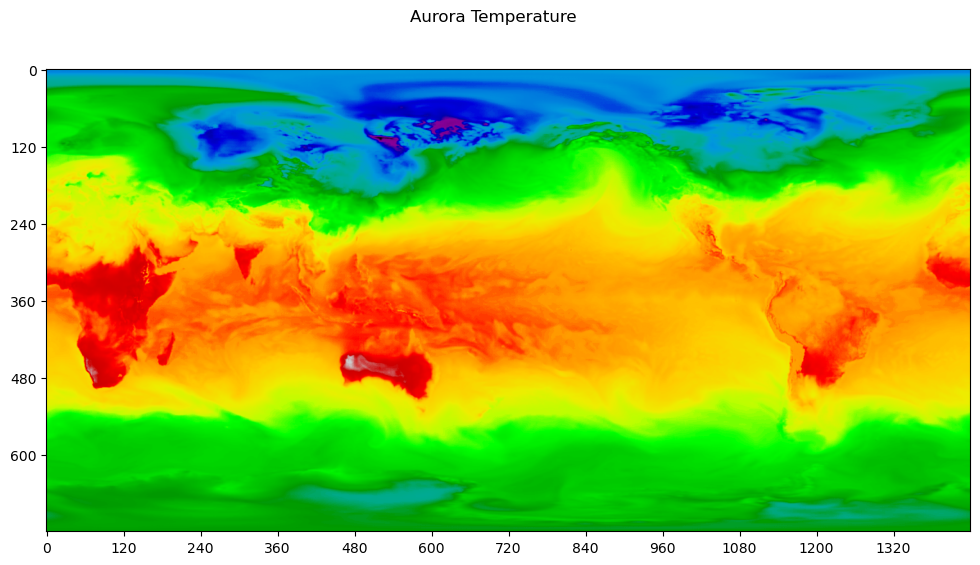

In [ ]:
# step 0, var v, batch 0, time 0, level 0 (1000), y 0, x 0
temp = aurora_preds['atmos_t'][0, 0, 0, :, :]

# Plot the a variable without a CRS
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(temp, cmap='nipy_spectral')
ax.set_xticks(np.arange(0, 1440, 120))
ax.set_yticks(np.arange(0, 720, 120))
fig.suptitle("Aurora Temperature")
plt.show()
plt.close(fig)

del temp

- [0, 0] appears to [Meridian, North Pole]
- Check what [0, 0] is for GFS data

### Read in GFS data to compare

In [ ]:
gfs_path = '/hdd0/archive/hail/gfs/20230101/gfs_select.t12z.pgrb2.0p25.f001.grb2'

# Check if the path file exists
if not os.path.exists(gfs_path):
    raise FileNotFoundError(f"File not found: {gfs_path}")
else:
    print(f"File found: {gfs_path}")

File found: /hdd0/archive/hail/gfs/20230101/gfs_select.t12z.pgrb2.0p25.f001.grb2


Ignoring index file '/hdd0/archive/hail/gfs/20230101/gfs_select.t12z.pgrb2.0p25.f001.grb2.5b7b6.idx' incompatible with GRIB file


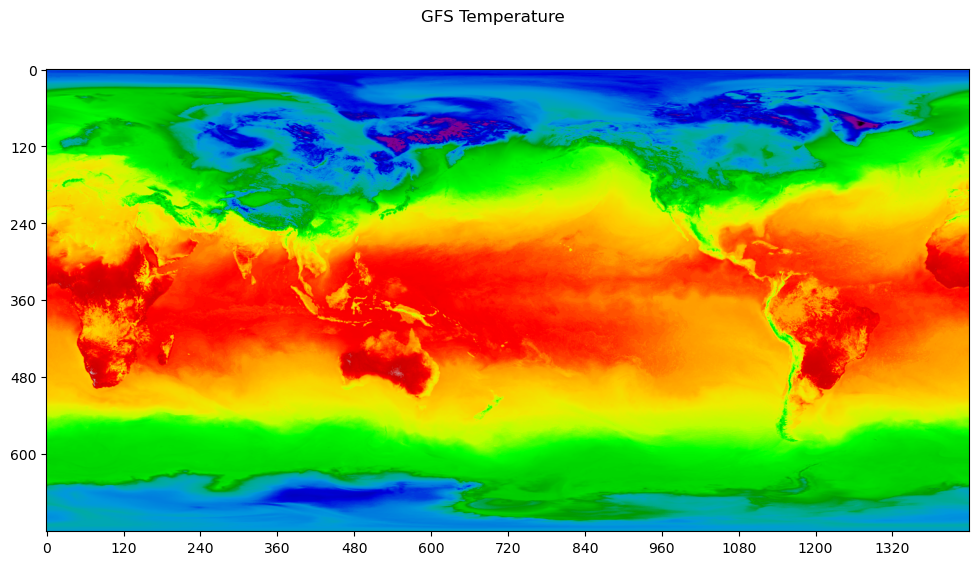

In [13]:
ds_gfs = xr.open_dataset(gfs_path, engine='cfgrib', backend_kwargs={'errors': 'ignore'})

gfs_temp = ds_gfs['t2m']

# Plot the a variable without a CRS
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(gfs_temp, cmap='nipy_spectral')
ax.set_xticks(np.arange(0, 1440, 120))
ax.set_yticks(np.arange(0, 720, 120))
fig.suptitle("GFS Temperature")
plt.show()
plt.close(fig)

# Delete the dataset
ds_gfs.close()
gfs_temp.close()

## Request & Visualize MyRadar Mosaic

In [14]:
idrive_endpoint = os.environ['IDRIVE_ENDPOINT']
idrive_bucket   = os.environ['IDRIVE_BUCKET']

idrive_secret   = os.environ['IDRIVE_ACCESS_SECRET']
idrive_key      = os.environ['IDRIVE_ACCESS_KEY']

print("IDrive: ")
print("\tEndpoint: ", idrive_endpoint)
print("\tBucket: ", idrive_bucket)

IDrive: 
	Endpoint:  https://l5l2.va.idrivee2-56.com
	Bucket:  archive-mosaics


In [15]:

output_path = "tiles"

dtg = datetime(2023, 1, 1, 0, 0, 0)

# Check if the mosaic dataset already exists
name = dtg.strftime('mosaic_CONUS_%Y_%m_%d_%H_%M.png')

full_path = os.path.join(output_path, name)

my_bucket = idrive_bucket
s3 = boto3.client('s3',
    endpoint_url          = idrive_endpoint,
    aws_access_key_id     = idrive_key,
    aws_secret_access_key = idrive_secret)
    
print("S3 Client Loaded: ", s3)

response = s3.list_buckets()
print("Buckets: ")
for bucket in response['Buckets']:
    print("\t", bucket['Name'])


yy, mon, dd, hh, mm, _ = dtg.strftime('%Y %m %d %H %M %s').split()
with BytesIO() as f:
    aa_path = dtg.strftime('mosaic/CONUS/%Y/%m/%d/%H/%M.png')
    print("AA File Path: ", aa_path)

    _ = s3.download_fileobj(my_bucket, aa_path, f)
    im = Image.open(f)

    out = np.asarray(im, np.uint8) # Single channel

# Get some grid information from the metadata from the PNG file.
im.getdata()
tileb = im.info['tile_bounds']
tileinfo = ast.literal_eval(tileb)
lb = tileinfo['TileMinX'] ; rb = tileinfo['TileMaxX']
bb = tileinfo['TileMinY'] ; tb = tileinfo['TileMaxY']
zoom = tileinfo['Zoom']

px = im.width // (rb - lb + 1) ; py = im.height // (tb - bb + 1)

scale = np.power(2,zoom)

xgrid = (np.float64(lb)*px + np.arange(0.,np.float64(im.width),1.0))/px
ygrid = (np.float64(bb)*py + np.arange(0.,np.float64(im.height),1.0))/py

xx,yy = np.meshgrid(xgrid,ygrid)

longitude = ( xx / scale  * 360.0) - 180.0
latitude = np.degrees(np.arctan( np.sinh( np.pi * (1.0  -  2.0 * yy / scale ) ) ) )

data_vars = { 'refl':(['y', 'x'], out,
                        {'units': 'dBZ*3',
                        'long_name':'compressed radar mosaic'})}
coords = {'longitude': (['y', 'x'], longitude),
            'latitude': (['y', 'x'], latitude)}

attrs = { 'description' : 'MyRadar mosaic' }

myradar_mosaic = xr.Dataset(data_vars = data_vars, coords = coords, attrs = attrs)

# Print coordinates from myradar mosaic
# Note that lat/lon is a meshgrid, with shape (y, x) for both
print("Mosaic Dims: ", myradar_mosaic.dims)
print("Mosaic Coords: ")
print(myradar_mosaic.coords)
print("Mosaic Lats: ", myradar_mosaic['latitude'].dtype, myradar_mosaic['latitude'].shape, myradar_mosaic['latitude'].values[:1], myradar_mosaic['latitude'].values[-1:])
print("Mosaic Lons: ", myradar_mosaic['longitude'].dtype, myradar_mosaic['latitude'].shape, myradar_mosaic['longitude'].values[:1], myradar_mosaic['longitude'].values[-1:])

S3 Client Loaded:  <botocore.client.S3 object at 0x7270fb347a10>
Buckets: 
	 archive-mosaics
	 archive-model
AA File Path:  mosaic/CONUS/2023/01/01/00/00.png


Mosaic Dims:  FrozenMappingWarningOnValuesAccess({'y': 4608, 'x': 7168})
Mosaic Coords: 
Coordinates:
    longitude  (y, x) float64 264MB -135.0 -135.0 -135.0 ... -56.27 -56.26
    latitude   (y, x) float64 264MB 55.78 55.78 55.78 ... 16.65 16.65 16.65
Mosaic Lats:  float64 (4608, 7168) [[55.77657302 55.77657302 55.77657302 ... 55.77657302 55.77657302
  55.77657302]] [[16.64671805 16.64671805 16.64671805 ... 16.64671805 16.64671805
  16.64671805]]
Mosaic Lons:  float64 (4608, 7168) [[-135.         -134.98901367 -134.97802734 ...  -56.28295898
   -56.27197266  -56.26098633]] [[-135.         -134.98901367 -134.97802734 ...  -56.28295898
   -56.27197266  -56.26098633]]


- Mosaic is on a curvilinear meshgrid, where lat/lon is individually defined for each grid point
- Lat and lon each have shape (4608, 7168)

In [16]:
myradar_mosaic

<xarray.Dataset> Size: 562MB
Dimensions:    (y: 4608, x: 7168)
Coordinates:
    longitude  (y, x) float64 264MB -135.0 -135.0 -135.0 ... -56.27 -56.26
    latitude   (y, x) float64 264MB 55.78 55.78 55.78 ... 16.65 16.65 16.65
Dimensions without coordinates: y, x
Data variables:
    refl       (y, x) uint8 33MB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    description:  MyRadar mosaic

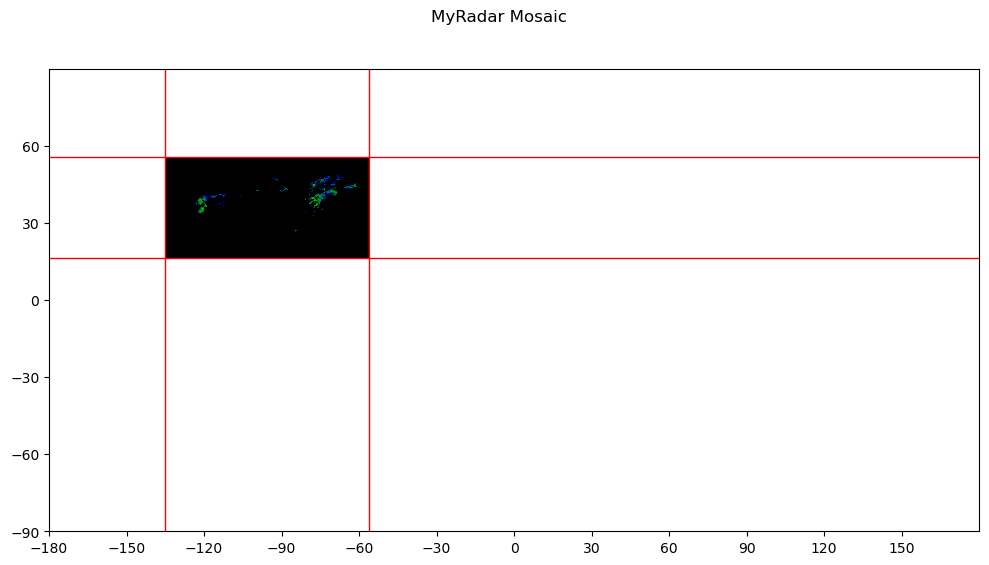

In [17]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

minlon = myradar_mosaic['longitude'].min().values
maxlon = myradar_mosaic['longitude'].max().values
minlat = myradar_mosaic['latitude'].min().values
maxlat = myradar_mosaic['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=myradar_mosaic['longitude'], y=myradar_mosaic['latitude'], s=0.01, c=myradar_mosaic['refl'], cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 180])
plt.ylim([-90, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 180, 30))
ax.set_yticks(np.arange(-90, 90, 30))
fig.suptitle("MyRadar Mosaic")
plt.show()
plt.close(fig)

### Attempt regridding with GFS data

In [18]:
regrid_path = config['inference']['interpolation_file']

regridder = xe.Regridder(ds_in=ds_gfs, ds_out=myradar_mosaic, method='bilinear', filename=regrid_path, reuse_weights=True)

ds_gfs_regrid = regridder(ds_gfs)

ds_gfs_regrid

<xarray.Dataset> Size: 2GB
Dimensions:                  (y: 4608, x: 7168)
Coordinates:
    time                     datetime64[ns] 8B 2023-01-01T12:00:00
    step                     timedelta64[ns] 8B 01:00:00
    heightAboveGround        float64 8B 2.0
    valid_time               datetime64[ns] 8B 2023-01-01T13:00:00
    pressureFromGroundLayer  float64 8B 3e+03
    surface                  float64 8B 0.0
    atmosphereSingleLayer    float64 8B 0.0
    isobaricInhPa            float64 8B 500.0
    isothermZero             float64 8B 0.0
    heightAboveGroundLayer   float64 8B 6e+03
    longitude                (y, x) float64 264MB -135.0 -135.0 ... -56.26
    latitude                 (y, x) float64 264MB 55.78 55.78 ... 16.65 16.65
Dimensions without coordinates: y, x
Data variables:
    t2m                      (y, x) float32 132MB 280.5 280.5 ... 298.7 298.7
    r                        (y, x) float32 132MB 80.6 80.68 ... 71.27 71.22
    cape                     (y, x) float32 132MB 2.681 2.563 ... 672.0 672.8
    cin                      (y, x) float32 132MB -0.641 -0.6756 ... 0.359 0.359
    pwat                     (y, x) float32 132MB 11.66 11.64 ... 33.57 33.52
    w                        (y, x) float32 132MB -0.1375 -0.1652 ... -0.1228
    gh                       (y, x) float32 132MB 1.752e+03 ... 4.501e+03
    unknown                  (y, x) float32 132MB 1.023e+03 ... 1.098e+03
    ustm                     (y, x) float32 132MB -4.649 -4.643 ... -7.053
    vstm                     (y, x) float32 132MB 19.43 19.41 ... -7.871 -7.877
Attributes:
    regrid_method:  bilinear

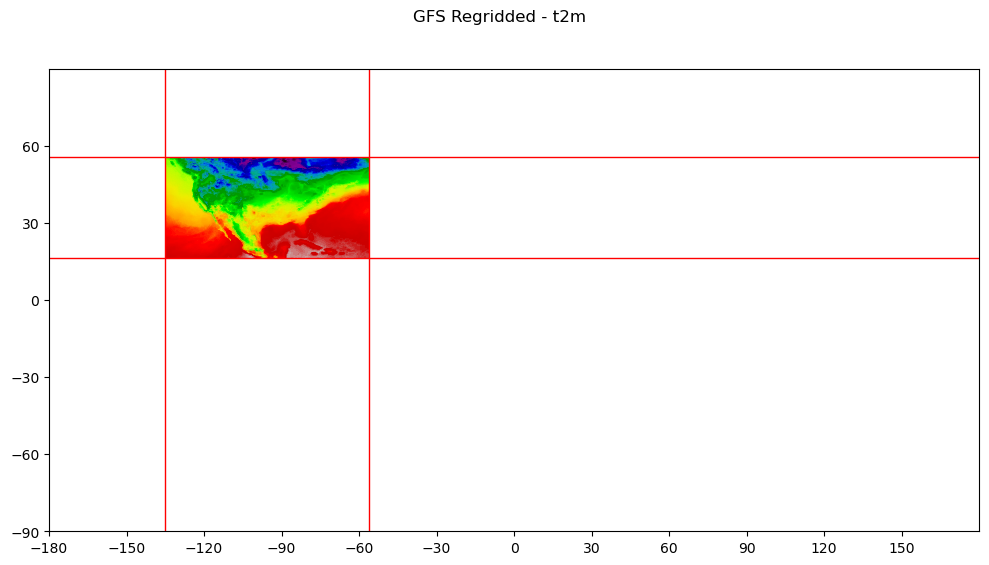

In [19]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

minlon = ds_gfs_regrid['longitude'].min().values
maxlon = ds_gfs_regrid['longitude'].max().values
minlat = ds_gfs_regrid['latitude'].min().values
maxlat = ds_gfs_regrid['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=ds_gfs_regrid['longitude'], y=ds_gfs_regrid['latitude'], s=0.01, c=ds_gfs_regrid['t2m'], cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 180])
plt.ylim([-90, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 180, 30))
ax.set_yticks(np.arange(-90, 90, 30))
fig.suptitle("GFS Regridded - t2m")
plt.show()
plt.close(fig)

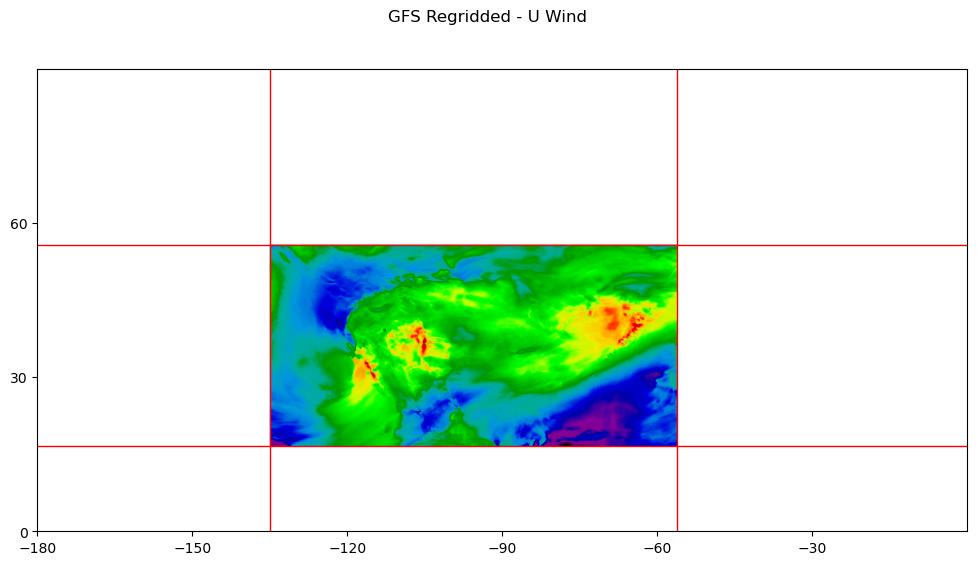

In [20]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

minlon = ds_gfs_regrid['longitude'].min().values
maxlon = ds_gfs_regrid['longitude'].max().values
minlat = ds_gfs_regrid['latitude'].min().values
maxlat = ds_gfs_regrid['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=ds_gfs_regrid['longitude'], y=ds_gfs_regrid['latitude'], s=0.01, c=ds_gfs_regrid['ustm'], cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 0])
plt.ylim([0, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 0, 30))
ax.set_yticks(np.arange(0, 90, 30))
fig.suptitle("GFS Regridded - U Wind")
plt.show()
plt.close(fig)

### Attempt regridding Aurora data

In [21]:
# Attempt to pad Aurora
# https://docs.xarray.dev/en/stable/generated/xarray.Dataset.pad.html
aurora_preds_padded = aurora_preds.pad({"latitude": (0, 1)}, mode='wrap')

# Reassign latitude values from [90, -89.75] to [90.0, -90.0]
new_lats = np.linspace(90.0, -90.0, 721)

print("New Lats: ", new_lats[:5], new_lats[-5:])

aurora_preds_padded = aurora_preds_padded.assign_coords(latitude=new_lats)

aurora_preds_padded

New Lats:  [90.   89.75 89.5  89.25 89.  ] [-89.   -89.25 -89.5  -89.75 -90.  ]


<xarray.Dataset> Size: 299MB
Dimensions:       (batch: 1, history: 1, latitude: 721, longitude: 1440,
                   level: 13, time: 1)
Coordinates:
  * longitude     (longitude) float32 6kB 0.0 0.25 0.5 ... 359.2 359.5 359.8
  * time          (time) datetime64[ns] 8B 2023-01-01T12:00:00
  * level         (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
    rollout_step  int64 8B ...
  * latitude      (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
Dimensions without coordinates: batch, history
Data variables:
    surf_2t       (batch, history, latitude, longitude) float32 4MB 247.8 ......
    surf_10u      (batch, history, latitude, longitude) float32 4MB 1.05 ... ...
    surf_10v      (batch, history, latitude, longitude) float32 4MB 2.815 ......
    surf_msl      (batch, history, latitude, longitude) float32 4MB 1.03e+05 ...
    static_z      (latitude, longitude) float32 4MB -1.24 -1.24 ... -1.24 -1.24
    static_slt    (latitude, longitude) float32 4MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    static_lsm    (latitude, longitude) float32 4MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    atmos_t       (batch, history, level, latitude, longitude) float32 54MB 2...
    atmos_u       (batch, history, level, latitude, longitude) float32 54MB -...
    atmos_v       (batch, history, level, latitude, longitude) float32 54MB -...
    atmos_q       (batch, history, level, latitude, longitude) float32 54MB 0...
    atmos_z       (batch, history, level, latitude, longitude) float32 54MB 2...

In [22]:
# Compare shape of GFS and Aurora
print("Shape: ")
print("\tGFS: ", ds_gfs['t2m'].shape)
print("\tAurora: ", aurora_preds['atmos_t'].shape)
print("\tAurora Padded: ", aurora_preds_padded['atmos_t'].shape)

# Compare latitude ranges of GFS and Aurora
print("Latitudes: ")
print("\tGFS: ")
print("\t\t", ds_gfs['latitude'].min().values, ds_gfs['latitude'].max().values)
print("\t\t", ds_gfs['latitude'].values[:5], ds_gfs['latitude'].values[-5:])

print("\tAurora: ")
print("\t\t",aurora_preds['latitude'].min().values, aurora_preds['latitude'].max().values)
print("\t\t", aurora_preds['latitude'].values[:5], aurora_preds['latitude'].values[-5:])

print("\tAurora Padded: ")
print("\t\t", aurora_preds_padded['latitude'].min().values, aurora_preds_padded['latitude'].max().values)
print("\t\t", aurora_preds_padded['latitude'].values[:5], aurora_preds_padded['latitude'].values[-5:])


Shape: 
	GFS:  (721, 1440)
	Aurora:  (1, 1, 13, 720, 1440)
	Aurora Padded:  (1, 1, 13, 721, 1440)
Latitudes: 
	GFS: 
		 -90.0 90.0
		 [90.   89.75 89.5  89.25 89.  ] [-89.   -89.25 -89.5  -89.75 -90.  ]
	Aurora: 
		 -89.75 90.0
		 [90.   89.75 89.5  89.25 89.  ] [-88.75 -89.   -89.25 -89.5  -89.75]
	Aurora Padded: 
		 -90.0 90.0
		 [90.   89.75 89.5  89.25 89.  ] [-89.   -89.25 -89.5  -89.75 -90.  ]


In [23]:
regrid_path = config['inference']['interpolation_file']

aurora_regridder = xe.Regridder(ds_in=aurora_preds_padded, ds_out=myradar_mosaic, method='bilinear', filename=regrid_path, reuse_weights=True)

ds_aurora_regrid = regridder(aurora_preds_padded)

ds_aurora_regrid 

<xarray.Dataset> Size: 10GB
Dimensions:       (batch: 1, history: 1, y: 4608, x: 7168, level: 13, time: 1)
Coordinates:
  * time          (time) datetime64[ns] 8B 2023-01-01T12:00:00
  * level         (level) int64 104B 1000 925 850 700 600 ... 250 200 150 100 50
    rollout_step  int64 8B 1
    longitude     (y, x) float64 264MB -135.0 -135.0 -135.0 ... -56.27 -56.26
    latitude      (y, x) float64 264MB 55.78 55.78 55.78 ... 16.65 16.65 16.65
Dimensions without coordinates: batch, history, y, x
Data variables:
    surf_2t       (batch, history, y, x) float32 132MB 280.4 280.4 ... 298.0
    surf_10u      (batch, history, y, x) float32 132MB -9.017 -9.028 ... -8.323
    surf_10v      (batch, history, y, x) float32 132MB 14.36 14.36 ... -1.133
    surf_msl      (batch, history, y, x) float32 132MB 9.969e+04 ... 1.017e+05
    static_z      (y, x) float32 132MB 8.914 10.66 12.41 ... -3.947 -4.318
    static_slt    (y, x) float32 132MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    static_lsm    (y, x) float32 132MB 1.246e-05 0.0005275 0.001042 ... 0.0 0.0
    atmos_t       (batch, history, level, y, x) float32 2GB 280.9 ... 207.8
    atmos_u       (batch, history, level, y, x) float32 2GB -8.947 ... 5.838
    atmos_v       (batch, history, level, y, x) float32 2GB 14.22 ... -6.132
    atmos_q       (batch, history, level, y, x) float32 2GB 0.00562 ... 3.045...
    atmos_z       (batch, history, level, y, x) float32 2GB -245.1 ... 2.018e+05
Attributes:
    regrid_method:  bilinear

In [28]:
# Save regridded output
ds_aurora_regrid.to_netcdf("tiles/aurora_predictions_regridded.nc")

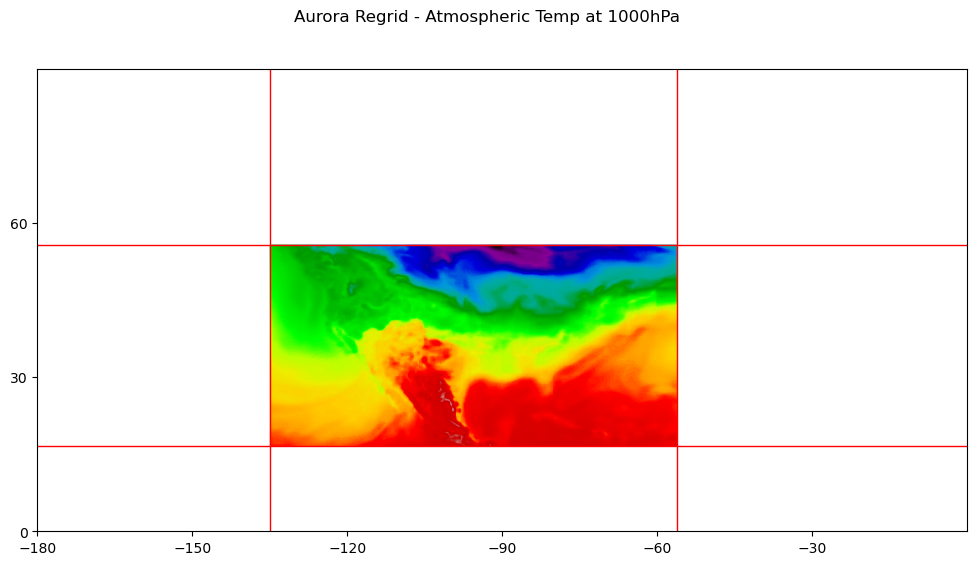

In [ ]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

selected_title = "Aurora Regrid - Atmospheric Temp at 1000hPa"
selected_ds = ds_aurora_regrid['atmos_t'].isel(batch=0, level=0, history=0)

minlon = ds_aurora_regrid['longitude'].min().values
maxlon = ds_aurora_regrid['longitude'].max().values
minlat = ds_aurora_regrid['latitude'].min().values
maxlat = ds_aurora_regrid['latitude'].max().values

# Plot the coordinate locations
plt.scatter(x=ds_aurora_regrid['longitude'], y=ds_aurora_regrid['latitude'], s=0.01, c=selected_ds, cmap='nipy_spectral', edgecolor='none')
plt.xlim([-180, 0])
plt.ylim([0, 90])

# Add lines for lon/lat range
ax.axhline(y=minlat, color='r', linewidth=1)
ax.axhline(y=maxlat, color='r', linewidth=1)
ax.axvline(x=minlon, color='r', linewidth=1)
ax.axvline(x=maxlon, color='r', linewidth=1)

ax.set_xticks(np.arange(-180, 0, 30))
ax.set_yticks(np.arange(0, 90, 30))
fig.suptitle(selected_title)
plt.show()
plt.close(fig)